<a href="https://colab.research.google.com/github/rithikkulkarni/Twitter-Sentiment-Stock-Price-Prediction/blob/main/basic_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score

In [2]:
CSV_FILE_PATH = 'https://raw.githubusercontent.com/rithikkulkarni/ALDA-Course-Project/refs/heads/main/datasets/filtered_stocks_test.csv'
TARGET_COLUMN = 'stock_performance'
NUMERICAL_FEATURES = ['one_day_price', 'two_day_price', 'three_day_price', 'historical_price'
                          , 'sentiment'
                      ]

TEST_SIZE = 0.2
RANDOM_STATE = 42

In [3]:
df = pd.read_csv(CSV_FILE_PATH)
# Shuffle the data
df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
print(f"Successfully loaded data. Shape: {df.shape}")
print("\nSample data:")
df.head(1)


print(df['stock_performance'].value_counts())

Successfully loaded data. Shape: (4184, 10)

Sample data:
stock_performance
-1    2171
 1    2013
Name: count, dtype: int64


The following cell gets an equal sample of data from each label to ensure that a valid accuracy that ins't inflated by a single label is achieved.

In [4]:
# Find the min class count across the classes
min_count = df['stock_performance'].value_counts().min()
print(f"min_count = {min_count}")

# Create a balanced dataframe by sampling min_count instances from each group
df = df.groupby('stock_performance').sample(n=min_count, random_state=42).reset_index(drop=True)

# Sanity check for class balance
print(df['stock_performance'].value_counts())

min_count = 2013
stock_performance
-1    2013
 1    2013
Name: count, dtype: int64


In [5]:
# Train/test split
X = df[NUMERICAL_FEATURES]
y = df[TARGET_COLUMN]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)
print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
X_train


Training set size: 3220
Test set size: 806


,one_day_price,two_day_price,three_day_price,historical_price,sentiment
274,150.76,152.41,168.17,163.21,0
866,332.17,332.92,328.20,329.74,0
231,369.68,385.62,379.02,368.58,0
2318,134.66,133.50,137.95,135.32,0
2261,166.37,177.66,173.10,231.36,0
...,...,...,...,...,...
1178,333.04,331.33,307.05,283.48,0
1630,124.30,132.57,175.80,170.31,0
454,262.22,258.88,258.74,274.31,0
3582,456.12,448.99,446.42,434.08,0


In [6]:
# Models
# Logistic Regression
model = LogisticRegression(multi_class='ovr', solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE)

print("\nTraining the model...")
model.fit(X_train, y_train)
coefficients = model.coef_[0]
print("Model training complete.")

# Predict
print("\nMaking predictions on the test set...")
y_pred = model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"\n--- Model Evaluation ---")
print(f"Accuracy: {accuracy:.4f}")


print("\nClassification Report:")
# Use labels=[-1, 0, 1] to ensure all classes are shown even if one is missing in predictions
print(classification_report(y_test, y_pred, labels=[-1, 0, 1], target_names=['Down (-1)', 'Neutral (0)', 'Up (1)'], zero_division=0))

print("\nConfusion Matrix:")
# Rows: Actual, Columns: Predicted
cm = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
print(pd.DataFrame(cm, index=['Actual Down', 'Actual Neutral', 'Actual Up'],
                   columns=['Predicted Down', 'Predicted Neutral', 'Predicted Up']))
print(coefficients)



Training the model...
Model training complete.

Making predictions on the test set...

--- Model Evaluation ---
Accuracy: 0.5000

Classification Report:
              precision    recall  f1-score   support

   Down (-1)       0.50      0.58      0.54       403
 Neutral (0)       0.00      0.00      0.00         0
      Up (1)       0.50      0.42      0.46       403

   micro avg       0.50      0.50      0.50       806
   macro avg       0.33      0.33      0.33       806
weighted avg       0.50      0.50      0.50       806


Confusion Matrix:
                Predicted Down  Predicted Neutral  Predicted Up
Actual Down                234                  0           169
Actual Neutral               0                  0             0
Actual Up                  234                  0           169
[ 0.00139276  0.00119582 -0.0018998  -0.00064757 -0.04529148]


In [7]:
# Switch target to pct change
X = df[NUMERICAL_FEATURES]
y = df['pct_change']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

# Model
model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
print("\nTraining the model...")
model.fit(X_train, y_train)
print("Model training complete.")

# Predict
print("\nMaking predictions on the test set...")
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

# Display results
print(f"\n--- Model Evaluation ---")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")
importances = model.feature_importances_
print(importances)



Training the model...
Model training complete.

Making predictions on the test set...

--- Model Evaluation ---
Mean Squared Error (MSE): 10.8778
Root Mean Squared Error (RMSE): 3.2981
R-squared (R2): -0.1276
[0.23121832 0.21837638 0.24302707 0.28538468 0.02199355]


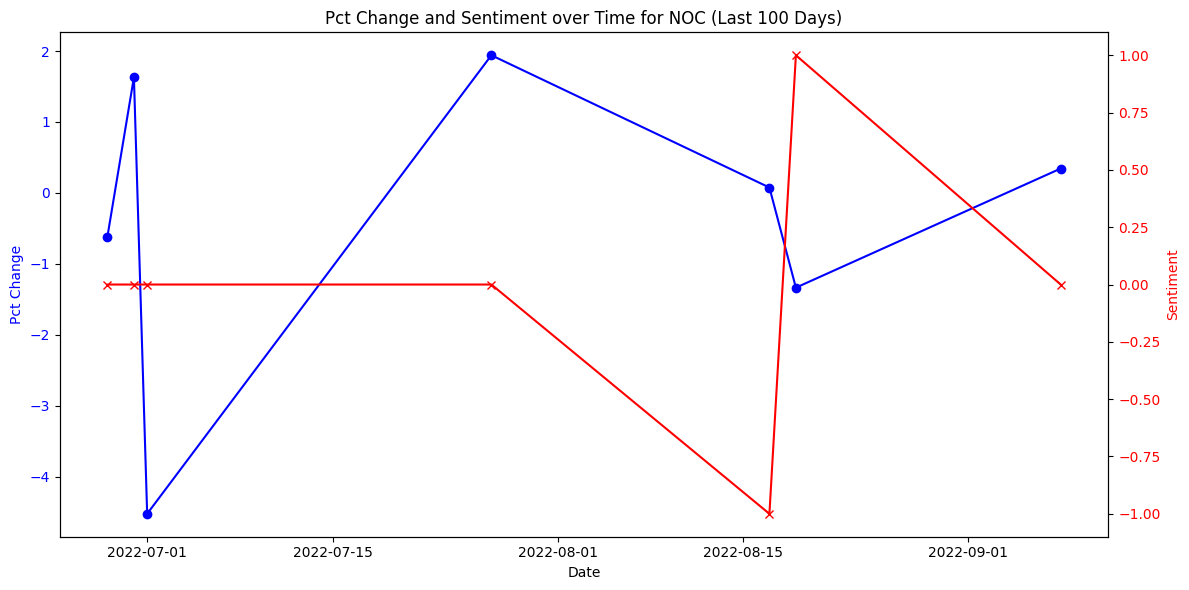

In [8]:
company_name = "NOC"
n = 100

# Choose company
df_company = df[df["Stock Name"] == company_name].copy()

# Sort by date
df_company["Date"] = pd.to_datetime(df_company["Date"])
df_company.sort_values("Date", inplace=True)

# Filter by n days
end_date = df_company["Date"].max()
start_date = end_date - pd.Timedelta(days=n - 1)
df_plot = df_company[(df_company["Date"] >= start_date) & (df_company["Date"] <= end_date)]

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot pct_change on the first y-axis
ax1.plot(df_plot["Date"], df_plot["pct_change"], color="blue", marker="o", label="Pct Change")
ax1.set_xlabel("Date")
ax1.set_ylabel("Pct Change", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Create a secondary y-axis for sentiment
ax2 = ax1.twinx()
ax2.plot(df_plot["Date"], df_plot["sentiment"], color="red", marker="x", label="Sentiment")
ax2.set_ylabel("Sentiment", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Add title and format x-axis labels for readability
plt.title(f"Pct Change and Sentiment over Time for {company_name} (Last {n} Days)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:
# Compute Pearson correlation for the filtered data (for the given company)
pearson_corr, pearson_p = pearsonr(df_plot['pct_change'], df_plot['sentiment'])
print(f"Pearson correlation for {company_name}: {pearson_corr:.4f}, p-value: {pearson_p:.4e}")

# Compute Spearman correlation for the filtered data (for the given company)
spearman_corr, spearman_p = spearmanr(df_plot['pct_change'], df_plot['sentiment'])
print(f"Spearman correlation for {company_name}: {spearman_corr:.4f}, p-value: {spearman_p:.4e}")


Pearson correlation for NOC: -0.1877, p-value: 6.8701e-01
Spearman correlation for NOC: -0.2673, p-value: 5.6231e-01


In [10]:
# Get the unique companies
companies = df["Stock Name"].unique()

# List for storing correlation results for each company
results = []

for company in companies:
    # Pull only current company
    company_data = df[df["Stock Name"] == company]

    # Check if there are enough observations
    if len(company_data) > 1:
        try:
            # Compute Pearson correlation (linear relationship)
            pearson_corr, pearson_p = pearsonr(company_data["pct_change"], company_data["sentiment"])
            # Compute Spearman correlation (monotonic relationship)
            spearman_corr, spearman_p = spearmanr(company_data["pct_change"], company_data["sentiment"])
        except Exception as e:
            # If any error occurs, set values to None
            pearson_corr, pearson_p, spearman_corr, spearman_p = None, None, None, None
    else:
        pearson_corr, pearson_p, spearman_corr, spearman_p = None, None, None, None

    # Add reuslts to dictionary
    results.append({
        "Stock Name": company,
        "Pearson Corr": pearson_corr,
        "Pearson p-value": pearson_p,
        "Spearman Corr": spearman_corr,
        "Spearman p-value": spearman_p
    })

# Create a new DataFrame from the results
df_corr = pd.DataFrame(results)
# print(df_corr)

# Sort by absolute value of Pearson or Spearman correlation
df_corr_sorted = df_corr.sort_values(by="Pearson Corr", key=lambda x: x.abs(), ascending=False)
print(df_corr_sorted)

   Stock Name  Pearson Corr  Pearson p-value  Spearman Corr  Spearman p-value
24        NOC      0.255865         0.227517       0.084905          0.693244
14          F     -0.166568         0.447484      -0.139460          0.525661
18         BX     -0.140238         0.494420      -0.123759          0.546951
5          BA      0.109169         0.189629       0.114000          0.170658
2        ENPH      0.097157         0.370664       0.051610          0.634972
8        INTC     -0.094149         0.290477      -0.113041          0.203927
10         KO     -0.091068         0.302801      -0.093840          0.288255
0        PYPL     -0.082644         0.270050      -0.080156          0.284784
21         ZS      0.080882         0.428526       0.109959          0.281104
9        MSFT     -0.075049         0.248776      -0.025080          0.700286
22       XPEV      0.065961         0.536785       0.063672          0.551034
7        COST     -0.062455         0.450793      -0.055654     

C:\Users\zeiad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\zeiad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [11]:
# Define the predictor variables and the target variable.
features = ['sentiment', 'one_day_price', 'two_day_price', 'three_day_price', 'historical_price']
X = df_plot[features]
y = df_plot['pct_change']

# Add a constant to the predictors (for the intercept)
X = sm.add_constant(X)

# OLS regression
model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             pct_change   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     2.912
Date:                Sat, 12 Apr 2025   Prob (F-statistic):              0.417
Time:                        23:21:31   Log-Likelihood:                -5.2157
No. Observations:                   7   AIC:                             22.43
Df Residuals:                       1   BIC:                             22.11
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -55.8911     38.660  

C:\Users\zeiad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
